In [1]:
from os import path as osp
import numpy as np
import tensorflow as tf
import sonnet as snt
from attrdict import AttrDict

from evaluation import make_fig, make_logger

from data import load_data, tensors_from_data
from mnist_model import AIRonMNIST

% matplotlib inline

In [2]:
learning_rate = 1e-5
n_steps = 3

results_dir = '../results'
run_name = 'discrete_empirical_baseline_uses_statistics'

logdir = osp.join(results_dir, run_name)
checkpoint_name = osp.join(logdir, 'model.ckpt')
axes = {'imgs': 0, 'labels': 0, 'nums': 1}

In [3]:
batch_size = 64
use_prior = True

num_steps_prior = AttrDict(
    anneal='exp',
    init=1. - 1e-7,
    final=1e-5,
    steps_div=1e4,
    steps=1e5,
    analytic=False,
)

appearance_prior = AttrDict(loc=0., scale=1.)
where_scale_prior = AttrDict(loc=.5, scale=1.)
where_shift_prior = AttrDict(scale=1.)

use_reinforce = True
discrete_steps = True
step_bias = 1.
transform_var_bias = -3.

init_explore_eps = .00

l2_weight = 0. #1e-5

In [4]:
valid_data = load_data('mnist_validation.pickle')
train_data = load_data('mnist_train.pickle')

In [5]:
tf.reset_default_graph()
train_tensors = tensors_from_data(train_data, batch_size, axes, shuffle=True)
valid_tensors = tensors_from_data(valid_data, batch_size, axes, shuffle=False)
x, valid_x = train_tensors['imgs'], valid_tensors['imgs']
y, test_y = train_tensors['nums'], valid_tensors['nums']
    
n_hidden = 32 * 8
n_layers = 2
n_hiddens = [n_hidden] * n_layers
    
air = AIRonMNIST(x, y,
                max_steps=n_steps, 
                explore_eps=init_explore_eps,
                inpt_encoder_hidden=n_hiddens,
                glimpse_encoder_hidden=n_hiddens,
                glimpse_decoder_hidden=n_hiddens,
                transform_estimator_hidden=n_hiddens,
                steps_pred_hidden=[128, 64],
                baseline_hidden=[256, 128],
                transform_var_bias=transform_var_bias,
                step_bias=step_bias,
                discrete_steps=discrete_steps)

In [6]:
train_step, global_step = air.train_step(learning_rate, l2_weight, appearance_prior, where_scale_prior,
                            where_shift_prior, num_steps_prior)

In [7]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
    
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
all_summaries = tf.summary.merge_all()

In [8]:
summary_writer = tf.summary.FileWriter(logdir, sess.graph)
saver = tf.train.Saver()

In [9]:
train_batches = train_data['imgs'].shape[0]
valid_batches = valid_data['imgs'].shape[0]
train_batches, train_batches = [i//100 for i in (train_batches, train_batches)]
log = make_logger(air, sess, summary_writer, train_tensors, train_batches, valid_tensors, valid_batches)

In [10]:
train_itr = sess.run(global_step)
print 'Starting training at iter = {}'.format(train_itr)

if train_itr == 0:
    log(0)

while train_itr < 1e6:
        
    train_itr, _ = sess.run([global_step, train_step])
    
    if train_itr % 1000 == 0:
        summaries = sess.run(all_summaries)
        summary_writer.add_summary(summaries, train_itr)
        
    if train_itr % 500 == 0:
        log(train_itr)
        
    if train_itr % 5000 == 0:
        saver.save(sess, checkpoint_name, global_step=train_itr)
        make_fig(air, sess, logdir, train_itr)    

Starting training at iter = 0
Step 0, Data train prior_loss = 32.7740, loss = 413.6338, baseline_loss = 323630.9566, kl_what = 1.5222, imp_weight = 413.6085, opt_loss = -52.2564, kl_num_steps = 14.6244, reinforce_loss = -465.8901, rec_loss = 380.8598, num_step = 1.6510, num_step_acc = 0.2153, kl_where = 16.6274, eval time = 0.7334s
Step 0, Data test prior_loss = 32.7406, loss = 411.8559, baseline_loss = 312024.8109, kl_what = 1.4792, imp_weight = 411.8290, opt_loss = -55.3138, kl_num_steps = 14.6243, reinforce_loss = -467.1697, rec_loss = 379.1153, num_step = 1.6516, num_step_acc = 0.2039, kl_where = 16.6371, eval time = 2.744s

Step 500, Data train prior_loss = 2.8909, loss = -222.3532, baseline_loss = 333.2168, kl_what = 0.0013, imp_weight = -8.0121, opt_loss = -222.4490, kl_num_steps = 2.8730, reinforce_loss = -0.0958, rec_loss = -225.2441, num_step = 0.0017, num_step_acc = 0.3212, kl_where = 0.0166, eval time = 0.1467s
Step 500, Data test prior_loss = 2.8923, loss = -230.7436, base

KeyboardInterrupt: 

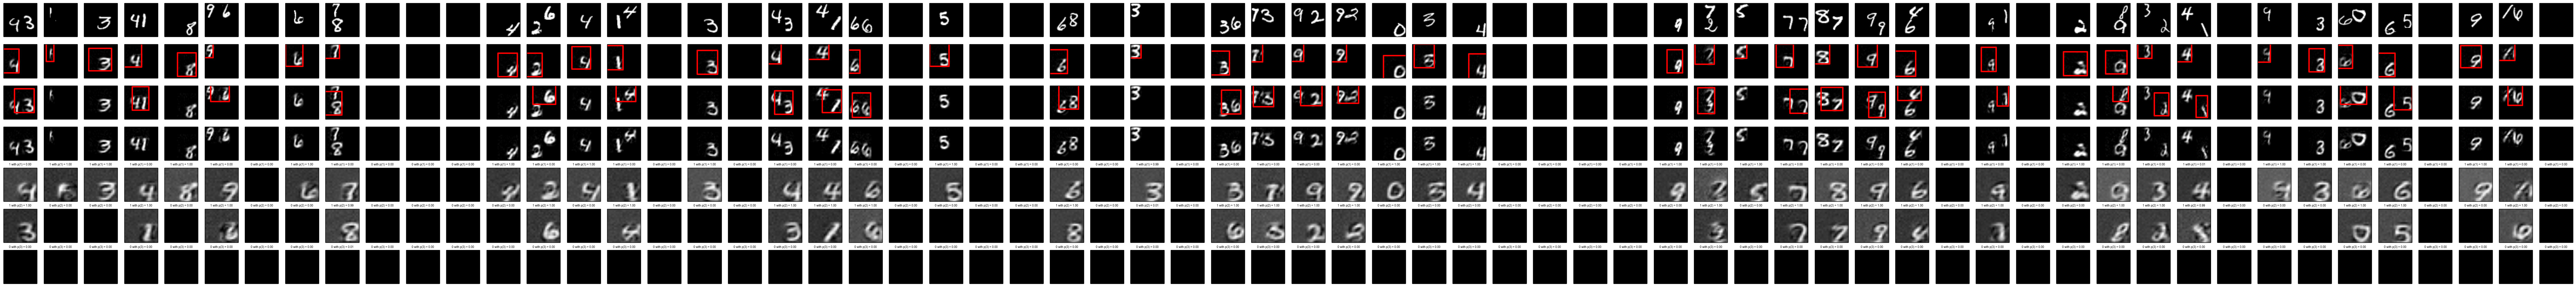

In [11]:
make_fig(air, sess, n_samples=64)